<a href="https://colab.research.google.com/github/gianluca-peri/demo-nasdaq/blob/main/demo_price_only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gdown
import os

filename = 'nq-12-24.txt'
id = '11qqmeXzP_jYcuYsJ382TP6M2dTuD5HDm'

replace = False

if replace:
  if os.path.exists(filename):
    os.remove(filename)

if not os.path.exists(filename):
  # Use gdown to download the file by its ID
  gdown.download(f'https://drive.google.com/uc?id={id}', filename)

# Reading
with open(filename, 'r') as f:
    content = f.read()

# Print the size of it in MB
print('\nSize of file:')
size_in_mb = round(os.path.getsize(filename) / (1024 * 1024), 2)
print(f'{size_in_mb:.2f} MB')

# Print the head of it
print('\nHead of file:')
print(content[:100])

Downloading...
From (original): https://drive.google.com/uc?id=11qqmeXzP_jYcuYsJ382TP6M2dTuD5HDm
From (redirected): https://drive.google.com/uc?id=11qqmeXzP_jYcuYsJ382TP6M2dTuD5HDm&confirm=t&uuid=58c764ae-7ff5-4ca4-8ffa-9decd9e5e153
To: /content/nq-12-24.txt
100%|██████████| 520M/520M [00:10<00:00, 51.3MB/s]



Size of file:
495.70 MB

Head of file:
20240930 220000 0120000;20234.25;20234.25;20234.25;2
20240930 220000 0200000;20234;20234;20234.5;2
2


In [ ]:
import torch

# Check if GPU is available

if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

print(f'Device: {device}!!')

Device: cuda!!


In [ ]:
import pandas as pd

# Reading it as a pd dataframe

data = pd.read_csv('nq-12-24.txt', sep=";", header=None)
data.columns = ["timestamp", "trade_price", "best_bid", "best_ask", "volume"]

data.head()

,timestamp,trade_price,best_bid,best_ask,volume
0,20240930 220000 0120000,20234.25,20234.25,20234.25,2
1,20240930 220000 0200000,20234.00,20234.00,20234.50,2
2,20240930 220000 0200000,20234.00,20234.00,20234.50,1
3,20240930 220000 0200000,20234.00,20234.00,20234.50,1
4,20240930 220000 0240000,20234.00,20234.00,20234.50,1


In [ ]:
# Turning the timestamp into a proper datetime object

data['timestamp'] = pd.to_datetime(data['timestamp'], format='%Y%m%d %H%M%S %f')
data.rename(columns={'timestamp': 'datetime'}, inplace=True)

# Turn from italian into Easter Time

data['datetime'] = data['datetime'].dt.tz_localize('Europe/Rome').dt.tz_convert('US/Eastern')

data.head()

,datetime,trade_price,best_bid,best_ask,volume
0,2024-09-30 16:00:00.012000-04:00,20234.25,20234.25,20234.25,2
1,2024-09-30 16:00:00.020000-04:00,20234.00,20234.00,20234.50,2
2,2024-09-30 16:00:00.020000-04:00,20234.00,20234.00,20234.50,1
3,2024-09-30 16:00:00.020000-04:00,20234.00,20234.00,20234.50,1
4,2024-09-30 16:00:00.024000-04:00,20234.00,20234.00,20234.50,1


In [ ]:
# We should check for presence of NaN values

for column in data.columns:
    print(f'Column {column} has {data[column].isna().sum()} NaN values\n')

Column datetime has 0 NaN values

Column trade_price has 0 NaN values

Column best_bid has 0 NaN values

Column best_ask has 0 NaN values

Column volume has 0 NaN values



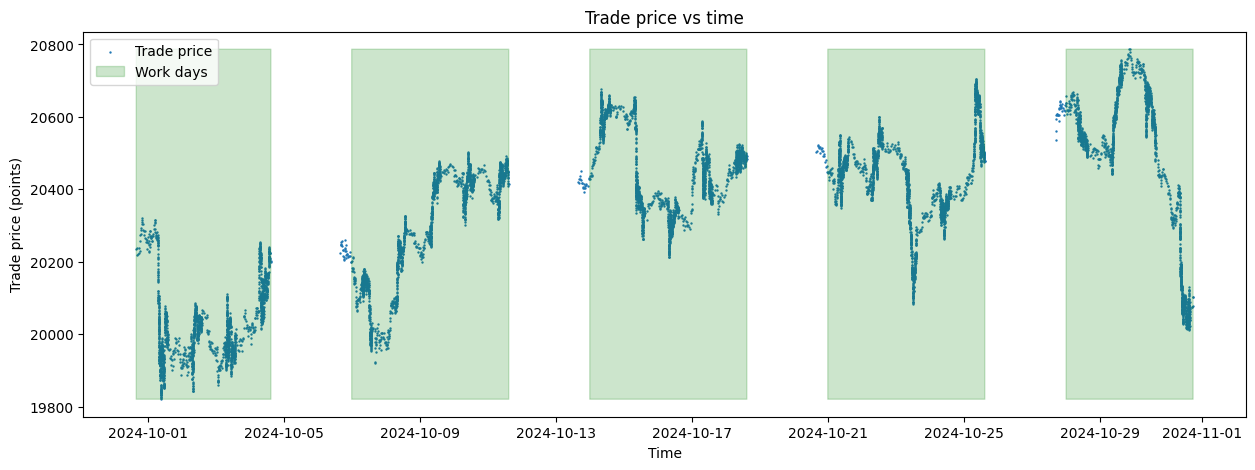

In [ ]:
from matplotlib import pyplot as plt

# Making a graph of trade price vs time

plt.figure(figsize=(15, 5))

# Select only one in a 1000 to plot
datetimes_plot = data['datetime'][::1000]
trade_prices_plot = data['trade_price'][::1000]

# Plot trade price
plt.scatter(datetimes_plot, trade_prices_plot, s=0.5, label='Trade price')

# Fill in green workdays

plt.fill_between(
    datetimes_plot,
    trade_prices_plot.min(),
    trade_prices_plot.max(),
    where=(datetimes_plot.dt.weekday < 5),
    color='green',
    alpha=0.2,
    label='Work days'
  )

plt.xlabel('Time')
plt.ylabel('Trade price (points)')
plt.title('Trade price vs time')
plt.legend(loc='upper left')
plt.show()

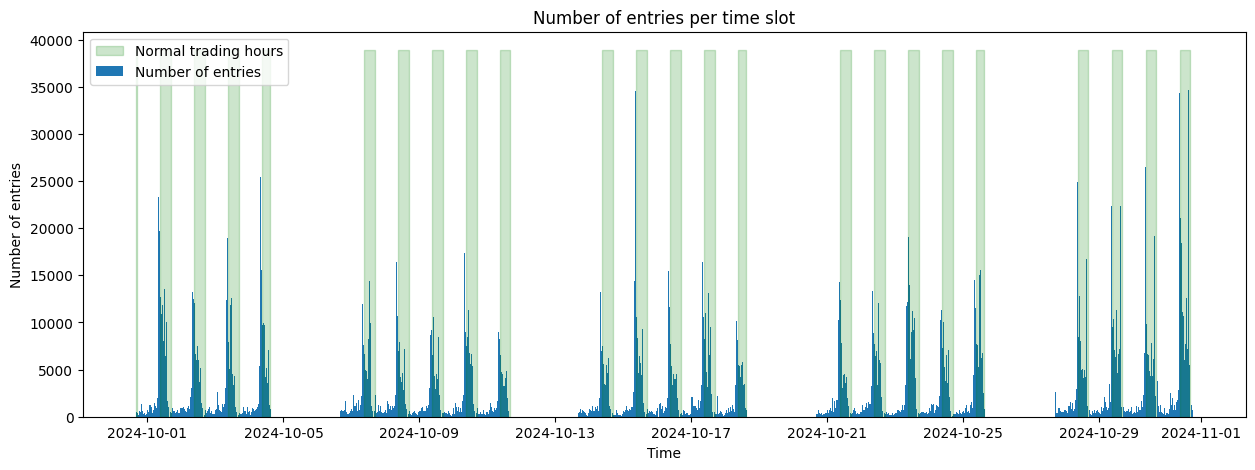

In [ ]:
# To clean the code we need to:
# Remove the weekends if present
# Remove the non standard trading periods

time_delta = pd.Timedelta(minutes=10)
start_time = data['datetime'][0]

# Create helper column
data['time_slot'] = (data['datetime'] - start_time) // time_delta

time_slot_counts = data['time_slot'].value_counts().sort_index()
time_slot_datetime = data.groupby('time_slot')['datetime'].first()

# Remove helper column
data.drop(columns=['time_slot'], inplace=True)

plt.figure(figsize=(15, 5))
plt.bar(
    x = time_slot_datetime,
    height = time_slot_counts,
    width = time_delta,
    label = 'Number of entries'
  )

# Fill in green data to keep
# (Normal trading is between 9/9:30 and 16:00)

plt.fill_between(
    time_slot_datetime,
    0,
    time_slot_counts.max(),
    where=((time_slot_datetime.dt.weekday < 5) & (time_slot_datetime.dt.hour >= 9) & (time_slot_datetime.dt.hour <= 16)),
    color='green',
    alpha=0.2,
    label='Normal trading hours'
  )

plt.legend(loc='upper left')
plt.xlabel('Time')
plt.ylabel('Number of entries')
plt.title('Number of entries per time slot')
plt.show()

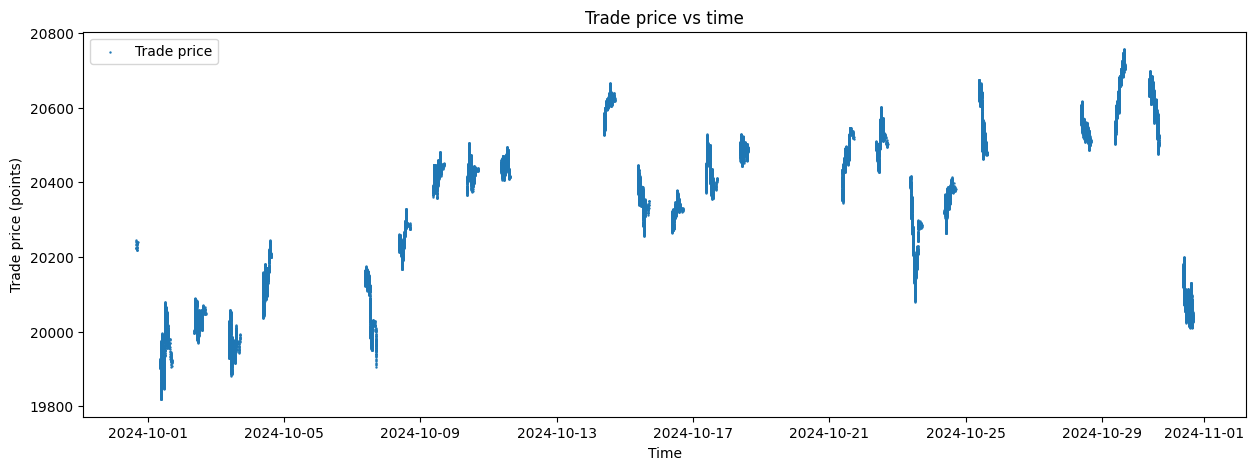

In [ ]:
# From the pandas dataset drop all the rows outside the normal trading hours
# (So get only the green parts)

data = data[(data['datetime'].dt.weekday < 5) & (data['datetime'].dt.hour >= 9) & (data['datetime'].dt.hour <= 16)]

# Make a plot

plt.figure(figsize=(15, 5))

# Select only one in a 1000 to plot
datetimes_plot = data['datetime'][::100]
trade_prices_plot = data['trade_price'][::100]

plt.scatter(datetimes_plot, trade_prices_plot, s=0.5, label='Trade price')

plt.title('Trade price vs time')
plt.xlabel('Time')
plt.ylabel('Trade price (points)')
plt.legend(loc='upper left')
plt.show()



In [ ]:
from tqdm.notebook import tqdm
# Create a list of timeseries with the trade prices, one for each day

do_only_the_first_4_days = True # 4 because the first is too short and will be eliminated

trade_prices_list = []
datetimes_list = []

for day in tqdm(data['datetime'].dt.date.unique(), desc='Building time series'):
    trade_prices_list.append(data[data['datetime'].dt.date == day]['trade_price'].tolist())
    datetimes_list.append(data[data['datetime'].dt.date == day]['datetime'].tolist())
    if do_only_the_first_4_days:
        if len(trade_prices_list) == 4:
            break

# Print lenght of lists

for index, a_list in enumerate(trade_prices_list):
    print(f'Lenght of the list for day {index}: {len(a_list)}')

# Get mean lenght

mean_lenght = sum([len(a_list) for a_list in trade_prices_list]) / len(trade_prices_list)
print(f'\nMean lenght: {mean_lenght}\n')

# Drop short outliers

trade_prices_list = [a_list for a_list in trade_prices_list if len(a_list) > mean_lenght*0.1]
datetimes_list = [a_list for a_list in datetimes_list if len(a_list) > mean_lenght*0.1]

# Print lenght of lists again

for index, a_list in enumerate(trade_prices_list):
    print(f'Lenght of the list for day {index}: {len(a_list)}')



Building time series:   0%|          | 0/24 [00:00<?, ?it/s]

Lenght of the list for day 0: 2793
Lenght of the list for day 1: 338328
Lenght of the list for day 2: 206105
Lenght of the list for day 3: 224106

Mean lenght: 192833.0

Lenght of the list for day 0: 338328
Lenght of the list for day 1: 206105
Lenght of the list for day 2: 224106


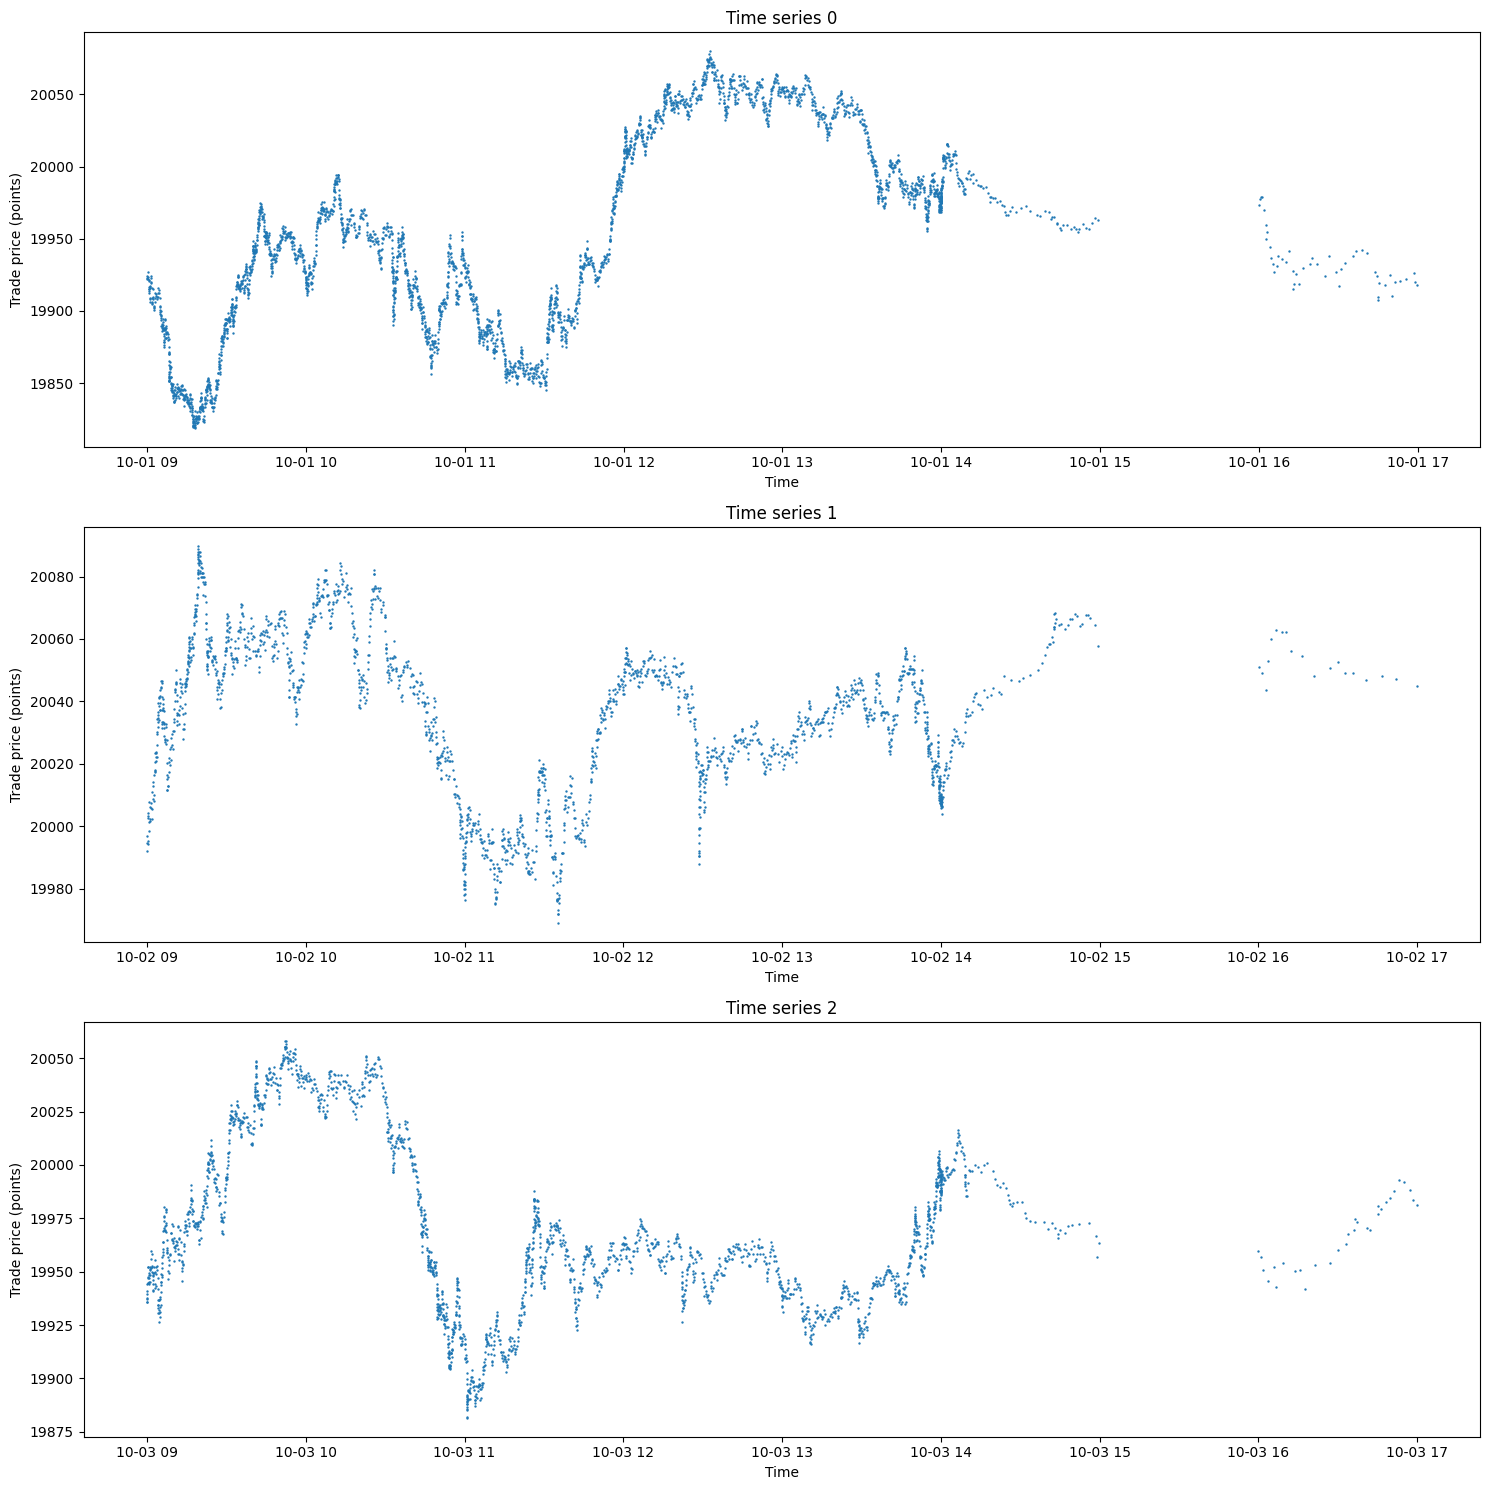

In [ ]:
# Plot each time series by itself in a multiplot

fig, axs = plt.subplots(len(trade_prices_list), 1, figsize=(15, 5*len(trade_prices_list)))

for index in range(len(trade_prices_list)):
    axs[index].scatter(datetimes_list[index][::100], trade_prices_list[index][::100], s=0.5, label='Trade price')
    axs[index].set_title(f'Time series {index}')
    axs[index].set_xlabel('Time')
    axs[index].set_ylabel('Trade price (points)')

plt.tight_layout()
plt.show()

In [ ]:
# Let's build a data dictionary for each day

data_dicts_list = []

for a_list in trade_prices_list:
    data_dicts_list.append({
        'x' : [i for i in range(len(a_list))],
        'y' : a_list
    })

In [ ]:
# We can use this, with pytorch, to create a custom dataset for classification

from torch.utils.data import Dataset

class SimpleTimeSeriesDataset(Dataset):
  def __init__(self, time_series, input_len, future_lookup_len, delta, stride, normalize):

    self.time_series = time_series
    self.input_len = input_len
    self.future_lookup_len = future_lookup_len
    self.delta = delta
    self.stride = stride
    self.normalize = normalize
    self.min_price = min(time_series['y'])
    self.max_price = max(time_series['y'])

    if normalize:
      self.time_series['y'] = [(y - self.min_price) / (self.max_price - self.min_price) for y in time_series['y']]
      self.delta = self.delta / (self.max_price - self.min_price)

    self.lenght_of_time_series = len(time_series['x'])
    self.slices = []

    points_since_last_save = 0
    for i in tqdm(range(self.lenght_of_time_series - input_len - future_lookup_len), desc='Building the classification dataset...'):
      if points_since_last_save > self.stride:
        self.slices.append({
            'x': time_series['x'][i:i+input_len+future_lookup_len],
            'y': time_series['y'][i:i+input_len+future_lookup_len]
        })
        points_since_last_save = 0
      else:
        points_since_last_save += 1

  def classify_time_series(self, y_past, y_future):
    last_known_y = y_past[-1]
    floor = last_known_y - self.delta
    ceiling = last_known_y + self.delta

    for point in y_future:
      if point > ceiling:
        # goes up
        return torch.tensor(0)
      elif point < floor:
        # goes down
        return torch.tensor(1)

    # neutral
    return torch.tensor(2)

  def __len__(self):
    return len(self.slices)

  def __getitem__(self, idx):
    current_slice = self.slices[idx]

    y_past = current_slice['y'][:self.input_len]
    y_future = current_slice['y'][self.input_len:]

    input_features_vector = torch.Tensor(y_past)
    correct_output = self.classify_time_series(y_past, y_future)

    return input_features_vector, correct_output

# Use 3 days to get train, validation, and test

TIME_DELTA_IN_DATAPOINTS = 1000
STRIDE = 100
DELTA = 10

train_dataset = SimpleTimeSeriesDataset(data_dicts_list[0], TIME_DELTA_IN_DATAPOINTS, TIME_DELTA_IN_DATAPOINTS, DELTA, STRIDE, normalize=True)
validation_dataset = SimpleTimeSeriesDataset(data_dicts_list[1], TIME_DELTA_IN_DATAPOINTS, TIME_DELTA_IN_DATAPOINTS, DELTA, STRIDE, normalize=True)
test_dataset = SimpleTimeSeriesDataset(data_dicts_list[2], TIME_DELTA_IN_DATAPOINTS, TIME_DELTA_IN_DATAPOINTS, DELTA, STRIDE, normalize=True)

# Print lenght

print(f'Lenght of train dataset: {len(train_dataset)}')
print(f'Lenght of validation dataset: {len(validation_dataset)}')
print(f'Lenght of test dataset: {len(test_dataset)}')

Building the classification dataset...:   0%|          | 0/336328 [00:00<?, ?it/s]

Building the classification dataset...:   0%|          | 0/204105 [00:00<?, ?it/s]

Building the classification dataset...:   0%|          | 0/222106 [00:00<?, ?it/s]

Lenght of train dataset: 3297
Lenght of validation dataset: 2001
Lenght of test dataset: 2177


In [ ]:
print('Checking train dataset\'s composition...')

number_of_goes_up_classes = 0
number_of_goes_down_classes = 0
number_of_neutral_classes = 0

for i in range(len(train_dataset)):
  input_features_vector, correct_output = train_dataset[i]
  if correct_output.item() == 0:
    number_of_goes_up_classes += 1
  elif correct_output.item() == 1:
    number_of_goes_down_classes += 1
  elif correct_output.item() == 2:
    number_of_neutral_classes += 1
  else:
    raise Exception('Unknown class')

print(f'Number of goes up classes in train: {number_of_goes_up_classes}')
print(f'Number of goes down classes in train: {number_of_goes_down_classes}')
print(f'Number of neutral classes in train: {number_of_neutral_classes}')

Checking train dataset's composition...
Number of goes up classes in train: 1036
Number of goes down classes in train: 1087
Number of neutral classes in train: 1174


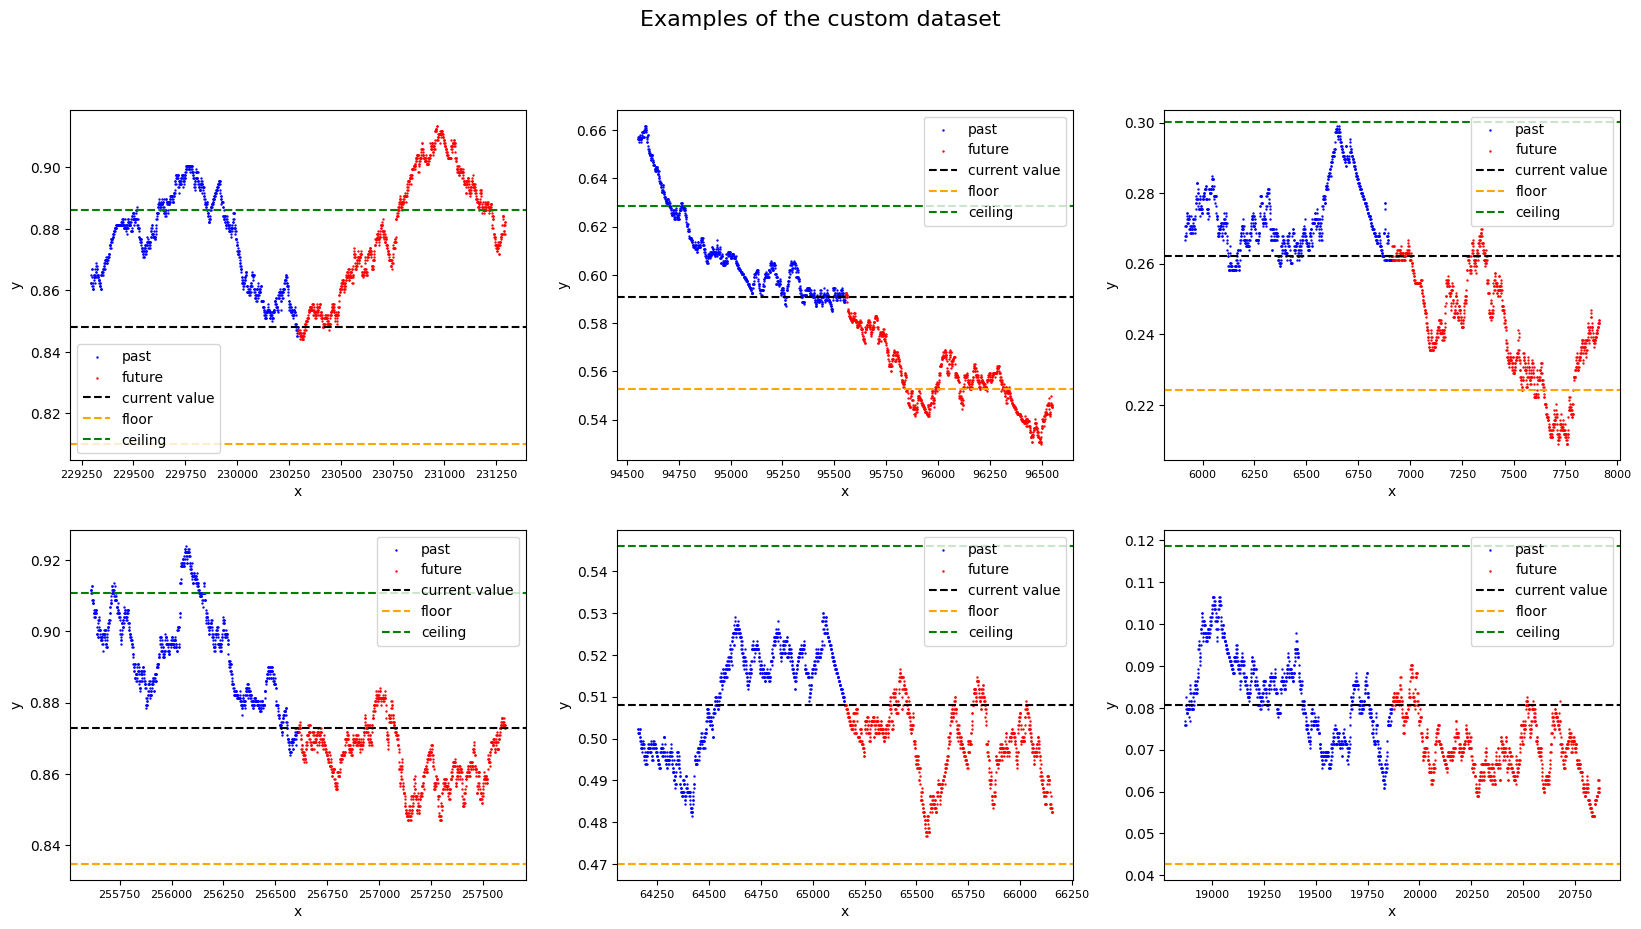

In [ ]:
import numpy as np

# Plot examples of the custom dataset

dataset = train_dataset

fig, ax = plt.subplots(2, 3, figsize=(20,10))

fig.suptitle('Examples of the custom dataset', fontsize=16)

for i in range(2):
  for j in range(3):
    k = np.random.randint(0, len(dataset))
    x_slice = dataset.slices[k]['x']
    y_slice = dataset.slices[k]['y']
    x_past = x_slice[:TIME_DELTA_IN_DATAPOINTS]
    y_past = y_slice[:TIME_DELTA_IN_DATAPOINTS]
    x_future = x_slice[TIME_DELTA_IN_DATAPOINTS:]
    y_future = y_slice[TIME_DELTA_IN_DATAPOINTS:]
    last_known_y = y_past[-1]
    floor = last_known_y - train_dataset.delta
    ceiling = last_known_y + train_dataset.delta
    ax[i][j].scatter(x_past, y_past, color='blue', s=0.5, label='past')
    ax[i][j].scatter(x_future, y_future, color='red', s=0.5, label='future')
    ax[i][j].axhline(y=last_known_y, color='black', linestyle='--', label='current value')
    ax[i][j].axhline(y=floor, color='orange', linestyle='--', label='floor')
    ax[i][j].axhline(y=ceiling, color='green', linestyle='--', label='ceiling')
    ax[i][j].legend()
    ax[i][j].set_xlabel('x')
    ax[i][j].set_ylabel('y')
    ax[i][j].tick_params(axis='x', labelsize=8)

plt.show()


# Model initialization

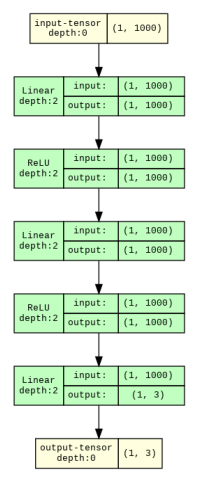

In [ ]:
!pip3 install torchview 1> /dev/null 2> /dev/null
from torchview import draw_graph
import matplotlib.image as mpimg
from torch import nn

# Now we can try to classify using a simple MLP

#-------------------------------------------------------------------------------
# MLP definition

class MLP(torch.nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()

    self.sequential = torch.nn.Sequential(
        nn.Linear(input_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, output_size),
    )

  def forward(self, x):
    return self.sequential(x)
#-------------------------------------------------------------------------------

input_size = TIME_DELTA_IN_DATAPOINTS
hidden_size = 1000
output_size = 3

model = MLP(input_size, hidden_size, output_size)

# Visualize the network

graph = draw_graph(model, input_size=(1, input_size)) # (batch_size, real_input_size)

# Render to PNG file
output_path = "model_graph"
graph.visual_graph.render(filename=output_path, format="png", cleanup=True)

# Load the image and display with matplotlib
img = mpimg.imread(f"{output_path}.png")
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis('off')
plt.show()

# Training and testing

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

epochs = 200

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

losses_train = []
losses_validation = []

# Use GPU

model.to(device)

for epoch in tqdm(range(epochs)):
  total_loss = 0
  model.train()
  for batch_idx, (input_features_vector, label) in enumerate(train_dataloader):
    input_features_vector = input_features_vector.to(device)
    label = label.to(device)
    optimizer.zero_grad()
    output = model(input_features_vector)
    loss = loss_fn(output, label)
    total_loss += loss.item()
    loss.backward()
    optimizer.step()
  losses_train.append(total_loss/len(train_dataloader))

  # Check validation
  total_loss = 0
  model.eval()
  with torch.no_grad():
    for batch_idx, (input_features_vector, label) in enumerate(validation_dataloader):
      input_features_vector = input_features_vector.to(device)
      label = label.to(device)
      output = model(input_features_vector)
      loss = loss_fn(output, label)
      total_loss += loss.item()
    losses_validation.append(total_loss/len(validation_dataloader))

# Making a plot of loss vs epochs

plt.plot(losses_train, label='train')
plt.plot(losses_validation, label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs epochs')
plt.show()

  0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Test the model to get the train accuracy

model.eval()
correct = 0
total = 0

with torch.no_grad():
  for batch_idx, (input_features_vector, label) in enumerate(train_dataloader):
    output = model(input_features_vector)
    for i in range(len(output)):
      if torch.argmax(output[i]) == label[i]:
        correct += 1
      total += 1

print(f'Accuracy on train: {correct/total}')


Accuracy on train: 0.40794661813770094


In [ ]:
# Test the model to get the accuracy

model.eval()
correct = 0
total = 0

with torch.no_grad():
  for batch_idx, (input_features_vector, label) in enumerate(test_dataloader):
    output = model(input_features_vector)
    for i in range(len(output)):
      if torch.argmax(output[i]) == label[i]:
        correct += 1
      total += 1

print(f'Accuracy on test: {correct/total}')



Accuracy on test: 0.3596692696371153


In [ ]:
# Test again with a confidence level

confidence = 0.8

model.eval()
correct = 0
wrong = 0
total = 0

with torch.no_grad():
  for batch_idx, (input_features_vector, label) in enumerate(test_dataloader):
    output = model(input_features_vector)
    for i in range(len(output)):
      if torch.max(output[i]) >= confidence:
        if torch.argmax(output[i]) == label[i]:
          correct += 1
        else:
          wrong += 1
      total += 1

print(f'Accuracy on test with confidence {confidence}: {correct/(correct+wrong)}')
print(f'Activity on test with confidence {confidence}: {(correct+wrong)/total}')

Accuracy on test with confidence 0.8: 0.21052631578947367
Activity on test with confidence 0.8: 0.017455213596692696


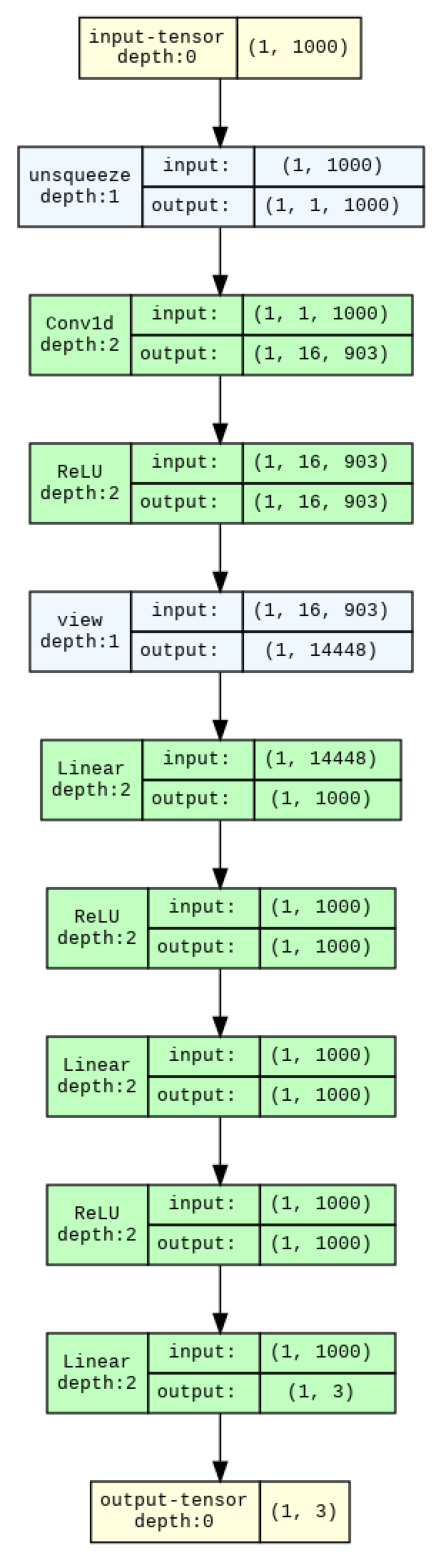

In [ ]:
# Let's do the same thing but with a CNN

class SimpleCNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, kernel_number=16, kernel_size=100, stride=1, padding=1):
        super().__init__()
        self.conv_net = nn.Sequential(
            nn.Conv1d(1, kernel_number, kernel_size, stride, padding),  # [B, 16, L]
            nn.ReLU()
        )

        self.flattened_size = kernel_number * ((input_size + 2 * padding - kernel_size) // stride + 1)

        self.fc = nn.Sequential(
            nn.Linear(self.flattened_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # [B, 1, L]
        x = self.conv_net(x)         # [B, 16, L]
        x = x.view(x.size(0), -1)    # Flatten: [B, 16 * L]
        logits = self.fc(x)          # [B, 3]
        return logits

model = SimpleCNN(TIME_DELTA_IN_DATAPOINTS, hidden_size, output_size)

# Visualize the network

graph = draw_graph(model, input_size=(1,input_size))

# Render to PNG file
output_path = "model_graph"
graph.visual_graph.render(filename=output_path, format="png", cleanup=True)

# Load the image and display with matplotlib
img = mpimg.imread(f"{output_path}.png")
plt.figure(figsize=(6,20))
plt.imshow(img)
plt.axis('off')
plt.show()


  0%|          | 0/200 [00:00<?, ?it/s]

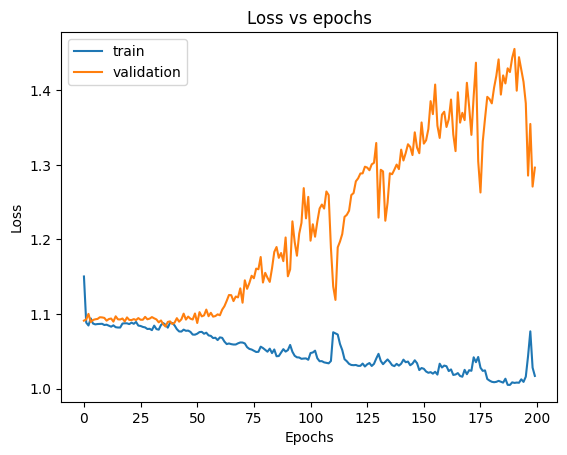

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

losses_train = []
losses_validation = []

# Use GPU

model.to(device)

for epoch in tqdm(range(epochs)):
  total_loss = 0
  model.train()
  for batch_idx, (input_features_vector, label) in enumerate(train_dataloader):
    input_features_vector = input_features_vector.to(device)
    label = label.to(device)
    optimizer.zero_grad()
    output = model(input_features_vector)
    loss = loss_fn(output, label)
    total_loss += loss.item()
    loss.backward()
    optimizer.step()
  losses_train.append(total_loss/len(train_dataloader))

  # Check validation
  total_loss = 0
  model.eval()
  with torch.no_grad():
    for batch_idx, (input_features_vector, label) in enumerate(validation_dataloader):
      input_features_vector = input_features_vector.to(device)
      label = label.to(device)
      output = model(input_features_vector)
      loss = loss_fn(output, label)
      total_loss += loss.item()
    losses_validation.append(total_loss/len(validation_dataloader))

# Making a plot of loss vs epochs

plt.plot(losses_train, label='train')
plt.plot(losses_validation, label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs epochs')
plt.show()

In [ ]:
# Test the model to get the train accuracy

model.eval()
correct = 0
total = 0

with torch.no_grad():
  for batch_idx, (input_features_vector, label) in enumerate(train_dataloader):
    output = model(input_features_vector)
    for i in range(len(output)):
      if torch.argmax(output[i]) == label[i]:
        correct += 1
      total += 1

print(f'Accuracy on train: {correct/total}')


Accuracy on train: 0.39338792841977555


In [ ]:
# Test the model to get the accuracy

model.eval()
correct = 0
total = 0

with torch.no_grad():
  for batch_idx, (input_features_vector, label) in enumerate(test_dataloader):
    output = model(input_features_vector)
    for i in range(len(output)):
      if torch.argmax(output[i]) == label[i]:
        correct += 1
      total += 1

print(f'Accuracy on test: {correct/total}')



Accuracy on test: 0.3256775378961874


In [ ]:
# Test again with a confidence level

confidence = 0.8

model.eval()
correct = 0
wrong = 0
total = 0

with torch.no_grad():
  for batch_idx, (input_features_vector, label) in enumerate(test_dataloader):
    output = model(input_features_vector)
    for i in range(len(output)):
      if torch.max(output[i]) >= confidence:
        if torch.argmax(output[i]) == label[i]:
          correct += 1
        else:
          wrong += 1
      total += 1

print(f'Accuracy on test with confidence {confidence}: {correct/(correct+wrong)}')
print(f'Activity on test with confidence {confidence}: {(correct+wrong)/total}')

Accuracy on test with confidence 0.8: 0.35384615384615387
Activity on test with confidence 0.8: 0.029857602204869087
